<a href="https://colab.research.google.com/github/emojivibe/upskill_campus_files/blob/main/code/Urvashi_pred_using_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [44]:
# Display only top 5 and bottom 5 rows
pd.set_option('display.max_rows', 10)

In [3]:
def nl():
    print('\n')

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
path="/content/drive/MyDrive/upskill campus_files/train_mc.csv"
df_train = pd.read_csv(path, parse_dates=[0], infer_datetime_format=True)
sath="/content/drive/MyDrive/upskill campus_files/test.csv"
df_test = pd.read_csv(sath, parse_dates=[0], infer_datetime_format=True)

nl()
print('Size of training set: ' + str(df_train.shape))
print(' Size of testing set: ' + str(df_test.shape))

nl()
print('Columns in train: ' + str(df_train.columns.tolist()))
print(' Columns in test: ' + str(df_test.columns.tolist()))

df_train.head()



Size of training set: (48120, 4)
 Size of testing set: (11808, 3)


Columns in train: ['DateTime', 'Junction', 'Vehicles', 'ID']
 Columns in test: ['DateTime', 'Junction', 'ID']


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


#Qick EDA

In [13]:
df_tmp = df_train.set_index(['Junction', 'DateTime'])

In [14]:
level_values = df_tmp.index.get_level_values

In [15]:
time_targets = df_tmp.groupby([level_values(0)] + [pd.Grouper(freq='1M', level=-1)])['Vehicles'].sum()

In [17]:
time_targets

Junction  DateTime  
1         2015-11-30    14736
          2015-12-31    15487
          2016-01-31    17940
          2016-02-29    20813
          2016-03-31    22215
                        ...  
4         2017-02-28     5564
          2017-03-31     4931
          2017-04-30     4454
          2017-05-31     4877
          2017-06-30     6097
Name: Vehicles, Length: 66, dtype: int64

In [18]:
del df_tmp
del time_targets

# Feature Engineering,lag_features

###Convert each junction as a column

In [19]:
train = df_train.pivot(index='DateTime',columns='Junction', values='Vehicles')
train

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,NaN
2015-11-01 01:00:00,13.0,6.0,7.0,NaN
2015-11-01 02:00:00,10.0,5.0,5.0,NaN
2015-11-01 03:00:00,7.0,6.0,1.0,NaN
2015-11-01 04:00:00,9.0,7.0,2.0,NaN
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


##Fill NaNs with 0 vehicles

In [20]:
train = train.fillna(0)

#Generate lag features

In [21]:
def gen_lag_features(df, n_in=1, n_out=1, dropnan=True):
    """
    Arguments:
        data: Dataframe of observations.
        n_in: Number of lag observations as input (X).
        n_out: Number of forecast observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Dataframe.
    """
    n_vars = df.shape[1]
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Junction %d (H-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Junction %d (H)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Junction %d (H+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        return agg

In [22]:
Xy_train = gen_lag_features(train)
Xy_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1),Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,,,,,
2015-11-01 01:00:00,15.0,6.0,9.0,0.0,13.0,6.0,7.0,0.0
2015-11-01 02:00:00,13.0,6.0,7.0,0.0,10.0,5.0,5.0,0.0
2015-11-01 03:00:00,10.0,5.0,5.0,0.0,7.0,6.0,1.0,0.0
2015-11-01 04:00:00,7.0,6.0,1.0,0.0,9.0,7.0,2.0,0.0
2015-11-01 05:00:00,9.0,7.0,2.0,0.0,6.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,95.0,34.0,38.0,17.0,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,105.0,34.0,33.0,11.0,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,96.0,35.0,31.0,30.0,90.0,31.0,28.0,16.0


#Normlize Features

In [23]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [24]:
# scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))

In [25]:
Xy_train[Xy_train.columns] = scaler.fit_transform(Xy_train[Xy_train.columns])

In [26]:
Xy_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1),Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,,,,,
2015-11-01 01:00:00,0.066225,0.106383,0.044693,0.000000,0.052980,0.106383,0.033520,0.000000
2015-11-01 02:00:00,0.052980,0.106383,0.033520,0.000000,0.033113,0.085106,0.022346,0.000000
2015-11-01 03:00:00,0.033113,0.085106,0.022346,0.000000,0.013245,0.106383,0.000000,0.000000
2015-11-01 04:00:00,0.013245,0.106383,0.000000,0.000000,0.026490,0.127660,0.005587,0.000000
2015-11-01 05:00:00,0.026490,0.127660,0.005587,0.000000,0.006623,0.021277,0.005587,0.000000
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,0.596026,0.702128,0.206704,0.472222,0.662252,0.702128,0.178771,0.305556
2017-06-30 20:00:00,0.662252,0.702128,0.178771,0.305556,0.602649,0.723404,0.167598,0.833333
2017-06-30 21:00:00,0.602649,0.723404,0.167598,0.833333,0.562914,0.638298,0.150838,0.444444


#Split train and valid (and normalize for real)

In [27]:
X_train = Xy_train[Xy_train.index < '2017-04-01'].iloc[:,0:4]
X_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1)
DateTime,,,,
2015-11-01 01:00:00,0.066225,0.106383,0.044693,0.000000
2015-11-01 02:00:00,0.052980,0.106383,0.033520,0.000000
2015-11-01 03:00:00,0.033113,0.085106,0.022346,0.000000
2015-11-01 04:00:00,0.013245,0.106383,0.000000,0.000000
2015-11-01 05:00:00,0.026490,0.127660,0.005587,0.000000
...,...,...,...,...
2017-03-31 19:00:00,0.476821,0.574468,0.178771,0.166667
2017-03-31 20:00:00,0.496689,0.531915,0.156425,0.222222
2017-03-31 21:00:00,0.483444,0.638298,0.156425,0.222222


In [28]:
y_train = Xy_train[Xy_train.index < '2017-04-01'].iloc[:,4:]
y_train

,Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,
2015-11-01 01:00:00,0.052980,0.106383,0.033520,0.000000
2015-11-01 02:00:00,0.033113,0.085106,0.022346,0.000000
2015-11-01 03:00:00,0.013245,0.106383,0.000000,0.000000
2015-11-01 04:00:00,0.026490,0.127660,0.005587,0.000000
2015-11-01 05:00:00,0.006623,0.021277,0.005587,0.000000
...,...,...,...,...
2017-03-31 19:00:00,0.496689,0.531915,0.156425,0.222222
2017-03-31 20:00:00,0.483444,0.638298,0.156425,0.222222
2017-03-31 21:00:00,0.403974,0.574468,0.150838,0.250000


#Reshape the Data

In [29]:
print(X_train.shape, y_train.shape)

(12407, 4) (12407, 4)


In [30]:
X_train = np.expand_dims(X_train.values, axis=2)
print(X_train.shape)

y_train = y_train.values
print(y_train.shape)

(12407, 4, 1)
(12407, 4)


#defining and training a model

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.initializers import he_normal

In [32]:
import keras.backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [33]:
# Initialising the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50,
                   activation = 'relu', # default is tanh
                   kernel_initializer = he_normal(seed=0),
                   input_shape = (None, 1)))

# Output for 4 junctions
regressor.add(Dense(units = 4))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = root_mean_squared_error)

In [34]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 128, epochs = 25, verbose = 1)

Epoch 1/25
97/97 [==============================] - 5s 8ms/step - loss: 0.0814
Epoch 2/25
97/97 [==============================] - 1s 8ms/step - loss: 0.0395
Epoch 3/25
97/97 [==============================] - 1s 8ms/step - loss: 0.0374
Epoch 4/25
97/97 [==============================] - 1s 8ms/step - loss: 0.0359
Epoch 5/25
97/97 [==============================] - 1s 8ms/step - loss: 0.0345
Epoch 6/25
97/97 [==============================] - 1s 9ms/step - loss: 0.0337
Epoch 7/25
97/97 [==============================] - 1s 8ms/step - loss: 0.0333
Epoch 8/25
97/97 [==============================] - 1s 8ms/step - loss: 0.0330
Epoch 9/25
97/97 [==============================] - 1s 8ms/step - loss: 0.0329
Epoch 10/25
97/97 [==============================] - 1s 8ms/step - loss: 0.0328
Epoch 11/25
97/97 [==============================] - 1s 8ms/step - loss: 0.0327
Epoch 12/25
97/97 [==============================] - 1s 11ms/step - loss: 0.0327
Epoch 13/25
97/97 [=============================

#Validating

In [35]:
X_valid = Xy_train[Xy_train.index >= '2017-04-01'].iloc[:,0:4]
X_valid

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1)
DateTime,,,,
2017-04-01 00:00:00,0.417219,0.553191,0.162011,0.166667
2017-04-01 01:00:00,0.384106,0.510638,0.122905,0.166667
2017-04-01 02:00:00,0.317881,0.574468,0.078212,0.138889
2017-04-01 03:00:00,0.238411,0.361702,0.083799,0.111111
2017-04-01 04:00:00,0.225166,0.361702,0.055866,0.111111
...,...,...,...,...
2017-06-30 19:00:00,0.596026,0.702128,0.206704,0.472222
2017-06-30 20:00:00,0.662252,0.702128,0.178771,0.305556
2017-06-30 21:00:00,0.602649,0.723404,0.167598,0.833333


In [36]:
X_valid = np.expand_dims(X_valid.values, axis=2)

In [37]:
y_pred = regressor.predict(X_valid)

69/69 [==============================] - 0s 3ms/step


In [38]:
# We rescale y in the integer count range
# To do that we must first reconcatenate with the X data as scaler expects a shape of 8

y_pred = scaler.inverse_transform(np.concatenate((X_valid.squeeze(), y_pred), axis = 1))[:, 4:]

In [39]:
y_pred

array([[65.10552904, 24.5558883 , 26.42394359,  7.4482289 ],
       [61.62354195, 22.90355155, 20.93087113,  7.01074076],
       [49.44025701, 22.98684612, 13.16944405,  5.18273968],
       ...,
       [76.93947628, 29.17363697, 23.16773017, 16.88054466],
       [84.40058661, 28.68519288, 29.22915126, 12.08679342],
       [76.34081674, 25.2410956 , 23.08340057, 14.33862054]])

In [40]:
y_truth = train[train.index >= '2017-04-01']
y_truth

Junction,1,2,3,4
DateTime,,,,
2017-04-01 00:00:00,63.0,25.0,23.0,6.0
2017-04-01 01:00:00,53.0,28.0,15.0,5.0
2017-04-01 02:00:00,41.0,18.0,16.0,4.0
2017-04-01 03:00:00,39.0,18.0,11.0,4.0
2017-04-01 04:00:00,31.0,15.0,10.0,1.0
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


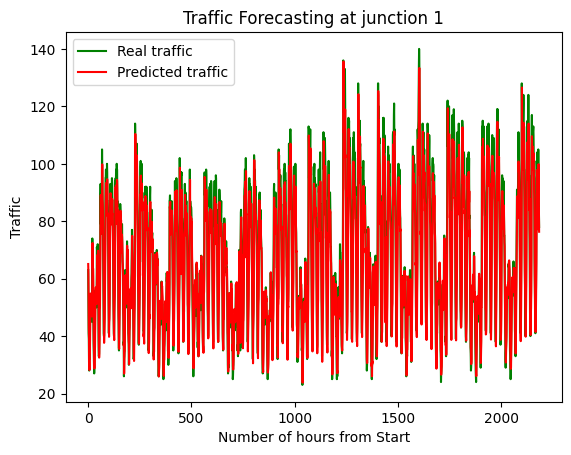

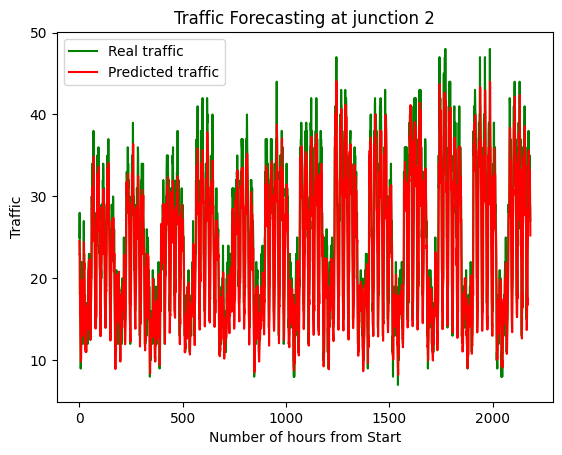

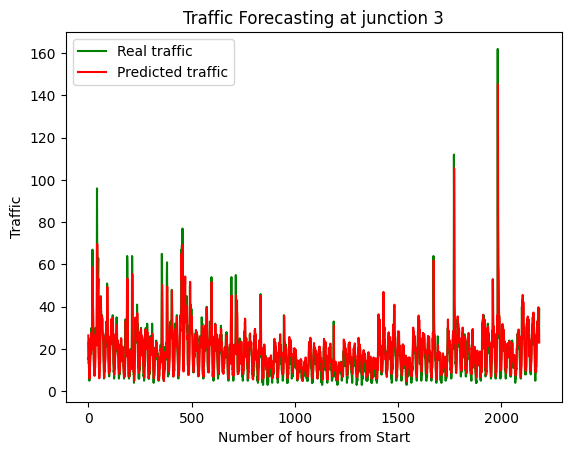

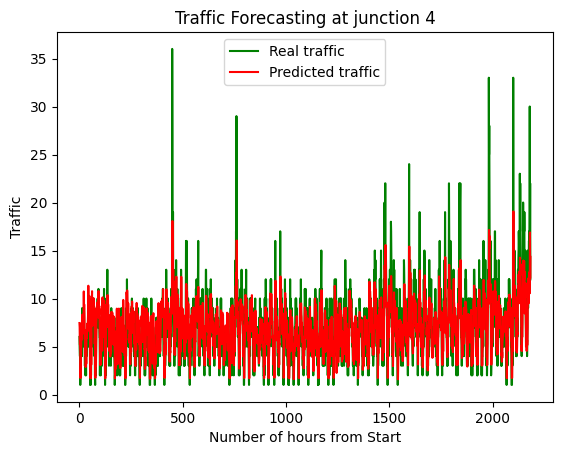

In [41]:
# Visualising Result for the junctions
for junction in range(4):
    plt.figure
    plt.plot(y_truth.values[:,junction], color = 'green', label = 'Real traffic')
    plt.plot(y_pred[:,junction], color = 'red', label = 'Predicted traffic')
    plt.title('Traffic Forecasting at junction %i' % (junction+1))
    plt.xlabel('Number of hours from Start')
    plt.ylabel('Traffic')
    plt.legend()
    plt.show()

In [42]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [43]:
rmse(y_truth, y_pred)

5.987196690309687